In [1]:
from analyzer import Analyzer, TestSubject
import sklearn
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import math

Setting Up TEST_SUBJECTS

In [2]:
control_start = datetime.datetime(year=2022, month=12, day=1)
control_end   = datetime.datetime(year=2022, month=12, day=3)

variant_start = datetime.datetime(year=2022, month=12, day=3)
variant_end   = datetime.datetime(year=2022, month=12, day=5)

control_subject = TestSubject(name="A", tested_from=control_start, tested_till=control_end, item_name="Apple", item_x = 4.2, item_y= -1.3)
variant_subject = TestSubject(name="B", tested_from=variant_start, tested_till=variant_end, item_name="Apple", item_x = 4.2, item_y= -1.3)

print(control_subject.to_string())
print(variant_subject.to_string())

A:
Test Period : 2022/12/01 00:00:00 ~ 2022/12/03 00:00:00
Target Item : Apple
 Located At : 4.2, -1.3
B:
Test Period : 2022/12/03 00:00:00 ~ 2022/12/05 00:00:00
Target Item : Apple
 Located At : 4.2, -1.3


LOADING DATAS

In [3]:
df_face_count = pd.read_json("aws_get_data/test_face_count_data.json")
df_local_data = pd.read_json("aws_get_data/test_local_data.json")
df_point_of_sale = pd.read_json("aws_get_data/test_point_of_sales_data.json")

print(df_face_count.head(5))
print(df_local_data.head(5))
print(df_point_of_sale.head(5))

   facecount  device_id      date   time                sample_time
0          0          0  20221208  14952 1970-08-23 01:00:08.014953
1          0          0  20221208  15308 1970-08-23 01:00:08.015309
2          0          0  20221208  15644 1970-08-23 01:00:08.015645
3          0          0  20221208  15539 1970-08-23 01:00:08.015551
4          0          0  20221208  15749 1970-08-23 01:00:08.015749
       y      date  user_id    time      x
0 -0.860  20221201    11143  103834  0.562
1 -0.438  20221201    11143  103840  1.348
2 -0.438  20221201    11143  103845  1.348
3 -0.286  20221201    11143  103849  1.403
4 -0.286  20221201    11143  103853  1.403
   count      date product_name    price  product_id market_name
0     14  20221201        Apple  1250000       11343   iPhone 14
1      2  20221202        Apple  1250000       11343   iPhone 14
2      5  20221203        Apple  1250000       11343   iPhone 14
3      8  20221204        Apple  1250000       11343   iPhone 14


In [4]:
my_analyzer = Analyzer([control_subject, variant_subject], df_point_of_sale, df_local_data, df_face_count)


[   count      date product_name    price  product_id market_name name
0     14  20221201        Apple  1250000       11343   iPhone 14    A
1      2  20221202        Apple  1250000       11343   iPhone 14    A,    count      date product_name    price  product_id market_name name
2      5  20221203        Apple  1250000       11343   iPhone 14    B
3      8  20221204        Apple  1250000       11343   iPhone 14    B]
       y      date  user_id    time      x name
0 -0.860  20221201    11143  103834  0.562    A
1 -0.438  20221201    11143  103840  1.348    A
2 -0.438  20221201    11143  103845  1.348    A
3 -0.286  20221201    11143  103849  1.403    A
4 -0.286  20221201    11143  103853  1.403    A         y      date  user_id    time      x name
50 -0.860  20221203    23123  103834  0.562    B
51 -0.438  20221203    23123  103840  1.348    B
52 -0.438  20221203    23123  103845  1.348    B
53 -0.286  20221203    23123  103849  1.403    B
54 -0.286  20221203    23123  103853  1.403 

In [5]:
def show_distribution(
    distributions
):
    n_control= distributions[0]['n']
    n_variant= distributions[1]['n']
    mean_control= distributions[0]['mean']
    mean_variant= distributions[1]['mean']
    var_control = distributions[0]['var']
    var_variant = distributions[1]['var']
    std_control = math.sqrt(var_control)
    std_variant = math.sqrt(var_variant)

    plt.style.use('default')
    plt.style.use('ggplot')

    control_x = np.linspace(mean_control - 3*std_control, mean_control + 3*std_control, 100)

    fig, ax = plt.subplots(figsize=(7, 3.5))

    ax.plot(control_x, stats.norm.pdf(control_x, mean_control, std_control), 'red', label="Control")
    ax.plot(control_x, stats.norm.pdf(control_x, mean_variant, std_variant), 'green', label="Variant")
    #ax.scatter(z_score, y_true, edgecolor='k', facecolor='red', alpha=0.7, label='This week data')

    ax.legend()
    #ax.text(0.55, 0.15, '$mean = %.2f std =%.2f $' % (mean, std ), fontsize=17, transform=ax.transAxes)

    fig.tight_layout()
    plt.show()
    
    return


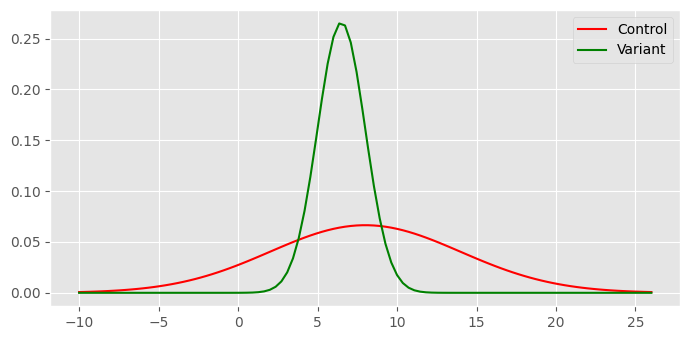

Z-Score : -0.3429971702850177
p_value : 0.36580029447995066
Reject the Null Hypothesis ? : False


In [10]:
sale_distribution, z_score, p_value = my_analyzer.sale_analysis()
show_distribution(sale_distribution)

print(f"Z-Score : {z_score}\np_value : {p_value}")
print(f"Reject the Null Hypothesis ? : {my_analyzer.do_reject_null_hypothesis(p_value)}")

/home/iknow/Desktop/IoTProject/src/analyzer.py:311: RuntimeWarning: invalid value encountered in double_scalars
  z_score = s_mean / np.sqrt(s_var)
/home/iknow/anaconda3/envs/test0/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


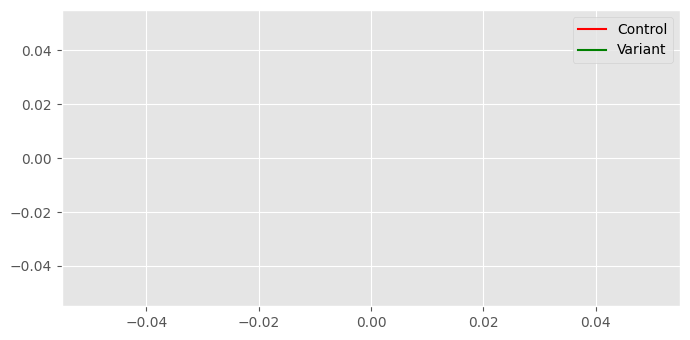

Z-Score : nan
p_value : nan
Reject the Null Hypothesis ? : False


In [11]:
time_spent_distribution, z_score, p_value = my_analyzer.time_spent_analysis()
show_distribution(time_spent_distribution)

print(f"Z-Score : {z_score}\np_value : {p_value}")
print(f"Reject the Null Hypothesis ? : {my_analyzer.do_reject_null_hypothesis(p_value)}")

/home/iknow/anaconda3/envs/test0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/iknow/anaconda3/envs/test0/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/iknow/anaconda3/envs/test0/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/iknow/anaconda3/envs/test0/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/iknow/anaconda3/envs/test0/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


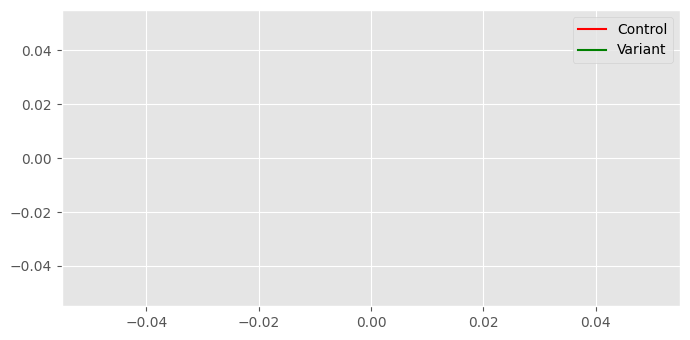

Z-Score : nan
p_value : nan
Reject the Null Hypothesis ? : False


In [12]:
face_count_distribution, z_score, p_value = my_analyzer.face_count_analysis()
show_distribution(face_count_distribution)

print(f"Z-Score : {z_score}\np_value : {p_value}")
print(f"Reject the Null Hypothesis ? : {my_analyzer.do_reject_null_hypothesis(p_value)}")